# Lab 3 Overview

Reminder that Project 1 is due this Friday.

## First Half
- Linear Regression.
- Evaluation Metrics.
- Penalized Regression (LASSO and Ridge).
- Generalised Linear Models (GLM).
- Discussion.

## Second Half
Revision:
- Any code related questions for Python.
- (Windows 10 Users) Installing WSL2 (Ubuntu 20.04) for a clean environment.

Advanced Content:
- Introduction to `PySpark` continued.

___________________

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from statsmodels.formula.api import *

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../data/lab_specific/100k_yellow_2015_05.csv")
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

As an example, let's try to predict `total_amount` using `fare_amount, tip_amount, toll_amount, trip_distance, VendorID` as predictors.

Some things to take note:
- `tip_amount` is only valid for `payment_type == 1` (card)
- `VendorID` is categorical, with only two possible values (`1` or `2`) so we should make it boolean

In [4]:
# filter dataframe
COL_FILTER = ['total_amount', 'fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']
df_filtered = df.loc[df['payment_type'] == 1, COL_FILTER].reset_index(drop=True)

# same as df_filtered['VendorID'].astype(bool)
df_filtered['VendorID'] = df_filtered['VendorID'] == 1 

df_filtered.tail()

,total_amount,fare_amount,tip_amount,tolls_amount,trip_distance,VendorID
61887,12.25,8.0,2.45,0.0,1.70,False
61888,8.16,5.0,1.36,0.0,0.89,False
61889,7.55,4.5,1.25,0.0,0.50,True
61890,11.80,9.0,2.00,0.0,1.80,True
61891,11.00,8.0,2.20,0.0,1.90,True


- We are looking for linear relationships between our chosen response `total_amount`.   
- Now I'm not sure what kind of life you've lived, but I'm fairly certain that we can infer that `total_amount` will have a positive linear relationship with `fare_amount`. Let's see a quick plot...

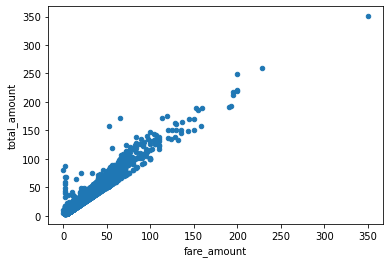

In [5]:
df_filtered[['total_amount', 'fare_amount']].plot.scatter(x='fare_amount', y='total_amount')
plt.show()

Well, obviously this looks like an overall positive linear relationship.
- How might we statistically test this?

-------

In R, we would do something like this for (Ordinary) Least Squares:
```R
>>> fit <- lm(total_amount~fare_amount + tip_amount + tolls_amount + trip_distance + VendorID ,data=dat_fit)
>>> summary(fit)
```
```
Call:
lm(formula = total_amount ~ fare_amount + tip_amount + tolls_amount +
trip_distance + VendorID, data = dat_fit)

Residuals:
Min     1Q      Median  3Q     Max
-1.4727 -0.3295 -0.1528 0.1747 1.7975

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    1.162154   0.002986 389.194  <2e-16 ***
fare_amount    0.993388   0.000315 3153.943 <2e-16 ***
tip_amount     1.006511   0.000826 1218.553 <2e-16 ***
tolls_amount   0.979325   0.001285 762.428  <2e-16 ***
trip_distance  0.011742   0.000963 12.194   <2e-16 ***
VendorIDTRUE  -0.003125   0.002914 -1.073    0.283
---
Signif. codes:
0 ^a˘A¨Y***^a˘A´Z 0.001 ^a˘A¨Y**^a˘A´Z 0.01 ^a˘A¨Y*^a˘A´Z 0.05 ^a˘A¨Y.^a˘A´Z 0.1 ^a˘A¨Y ^a˘A´Z 1

Residual standard error: 0.362 on 61886 degrees of freedom
Multiple R-squared: 0.9994,          Adjusted R-squared: 0.9994
F-statistic: 1.953e+07 on 5 and 61886 DF, p-value: < 2.2e-16
```

Well, whatever you can do in R can also done in Python (to an extent).  
Documentation Source: https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html?highlight=ols

In [12]:
fit = ols(formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance + VendorID",
         data=df_filtered).fit()

In [13]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.953e+07
Date:                Tue, 10 Aug 2021   Prob (F-statistic):               0.00
Time:                        12:29:26   Log-Likelihood:                -24933.
No. Observations:               61892   AIC:                         4.988e+04
Df Residuals:                   61886   BIC:                         4.993e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1622      0.003  

- The table structure is a bit different, though it is identical in value with R's output.  
- The coefficient table is the same, but now includes a 95% CI for the beta coefficients.



___________________

Questions:
- Is this model good?
    - The $R^2$ value is 0.999 which is insanely large. As a rule of thumb, large $R^2$ values indicate a good fit. 
    - *Perhaps too good of a fit...*
    - AIC itself isn't important, however, if we compare it to another model (let's say an alternative model with different features chosen)...
    - If we have a hypothesis for a null model ($\beta=0$) vs our fitted model ($\beta\neq0$), then we can look at the `F-statistc = 1.953e+07`. 
    - The corresponding p-value of  this F statistic is `0.00`, which is less than $\alpha=0.05$, so we can conclude that our fitted model is better than a null model. 
    - In other words, we reject the null hypothesis and conclude that we believe the intercept parameters to be non-zero.
    
    
- How might we improve this model?
    - If we look at the parameters, we may wish to exclude `VendorID[T.True]` as it is not significant with p-value `0.283 > 0.05`. Perhaps we should drop this attribute and fit another model without it.
    - Additionally, we can do some feature engineering (run a decision tree and look at the splits)

In [16]:
fitter = ols(formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance",
         data=df_filtered).fit()
print(fitter.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.441e+07
Date:                Tue, 10 Aug 2021   Prob (F-statistic):               0.00
Time:                        12:30:49   Log-Likelihood:                -24933.
No. Observations:               61892   AIC:                         4.988e+04
Df Residuals:                   61887   BIC:                         4.992e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1606      0.003    440.908

___________________

Now that we have to values of AIC to compare with, which one is better...?
- Well, we see a small decrease in AIC and a large decrease in BIC. Hence, we can say that the model without `VendorID` is better.

In [17]:
[fit.aic, fitter.aic], [fit.bic, fitter.bic]

([49877.70777173292, 49876.858381244325],
 [49931.90664899058, 49922.024112292376])

----------

## Penalized Regression
- LASSO (l1) and Ridge (l2) Regression

Revise in your own time if you've forgotten (this was covered in MAST30025):
- Lecture 4 (variable selection)
- LSM topic 5 (`ch05_handout`) slide 141/141
- An excellent explanation on Ridge / LASSO: https://www.youtube.com/watch?v=9LNpiiKCQUo (recommended at x1.25 speed)

Things you might have forgotten when working with penalized models:
- Always good to standardize your data prior to train and test. Most models perform poorly if not standardized prior. 
- Do not fit your standardizer to test, only to train. You should transform both your train and test though.

### LASSO ($\ell_1$)
Quick overview:
- LASSO may cause coefficients to be set to 0 by constraining the model.
- This is because we put a constraint where the sum of the absolute values of the coefficients must be less than some fixed value. 
- As such, some coefficients may end up having 0 which is the same as *dropping* the attribute from the model. Notably, features that are collinear (correlated) will result in one of them being reduced to 0 coefficient.
- In this sense, it's quite similar to feature selection as you end up with a model that is much more simpler. 
- However, LASSO does not do well when the feature space is small as you may end up with an over-simplified model, as well as cases where all the features are significant or when coefficients are extremely large. 
- This is why you might want to standardize your dataset prior to fitting.

Solution:
- Requires an iterative method to solve $(\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda I \beta$
- The $\ell_1$ (vector normal) comes from the penalty term $\lambda I \beta$. Our $\beta$ term is to the power of 1, hence we have $\ell_1$.

### Ridge ($\ell_2$)
Quick overview:
- Also know as the MAP (Maximum a posteriori) estimation.
- Aims to lower the scale of the coefficients to avoid overfitting, but does not result in coefficients being 0.
- In contrast to LASSO, we put a constrain using the sum of squares that must be lest than a fixed value. 
- As you might guess, this means we still have several features making it less interpretable than LASSO.
- However, Ridge Regression performs best in cases where there may be high multi-colinearity (i.e dependencies between attributes) or high linear correlation between certain attributes,
- This is because it reduces variance in exchange for some more bias (consider variance-bias tradeoff).
- You must also ensure that we have more observations than attributes (`n > p`) as this penalty method does not drop features, leading to worse predictions. 

Solution:
- Closed-form which can be found by minimising $(\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda I \beta^T\beta$
- The $\ell_2$ (vector normal) comes from the penalty term $\lambda I \beta^T\beta$. Since the $\beta$ term is squared, we have $\ell_2$.
- Good to practice and show that minimising the equation above yields the \

### Elastic Net
Quick overview:
- Combines both Ridge and LASSO into a single model utilising an $\alpha$ parameter, where $\alpha=0$ is Ridge and $\alpha=1$ is LASSO.
- Implementation Documentation: https://github.com/civisanalytics/python-glmnet/blob/master/glmnet/linear.py

In [18]:
yCOLS = ['total_amount']
xCOLS = ['fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']

# standardize (by calculating the zscore) so our data has mean 0 and var 1
# alternatively, you can use sklearn's StandardScalar

from scipy.stats import zscore
df_standard = df_filtered[xCOLS].astype(float).apply(zscore)

In [19]:
# format output to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format
df_standard.describe().loc[['mean','std']]

,fare_amount,tip_amount,tolls_amount,trip_distance,VendorID
mean,0.0000,0.0000,-0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000


As you can see, `df_standard` has  $\mu=0, \sigma=1(=\sigma^2)$  

In [20]:
from glmnet import ElasticNet

lasso_fit = ElasticNet(alpha=1)
lasso_fit.fit(df_standard.values, df_filtered[yCOLS].values)

ElasticNet()

Now, we want to look at the shrinking parameter $\lambda$.  

In [21]:
# this can be accessed using the .lambda_best_ method after fitting!
print(f'Best lambda value for LASSO: {lasso_fit.lambda_best_[0]}')

Best lambda value for LASSO: 0.23665078615126328


$\lambda$ is computed by using cross validation (iterative approach).

What about our coefficients?
- https://github.com/civisanalytics/python-glmnet/blob/master/glmnet/linear.py

In [22]:
pd.DataFrame(index = ['Intercept'] + xCOLS, 
             data= [lasso_fit.intercept_] + list(lasso_fit.coef_), 
             columns = ['Coefficient'])

,Coefficient
Intercept,18.0736
fare_amount,11.2272
tip_amount,2.5958
tolls_amount,1.3317
trip_distance,0.0000
VendorID,0.0000


As you can see, `trip_distance` and `VendorID` have *shrunk* to 0. You can use `lasso_fit.predict(x)` to the predict a new set of observations by passing through the `x` matrix

___________________

## Fitting a GLM (Optional)
- Well, this is exactly what some of you will be learning in MAST30027 right now.

Let's go through an example:
- The `passenger_count` attribute is discrete and non-negative. If we were to predict it, a linear model will not be sufficient. 
- We know that a Poisson distribution takes in non-negative integer values, so we can use the Poisson family of GLMs to model this. 
- We will use `total_amount, trip_distance, VendorID` as our regressors.

For those of you not taking MAST30027 (ELI5):
- GLM's allow us to express relationships in a linear and additive way like normal linear regression.
- However, it might be the case that the underlying true relationship is neither linear nor additive. 
- The transformation is done through a *link function* (in this case, Poisson).

In [23]:
from statsmodels.api import families

# convert VendorID to categorical
df['VendorID'] = df['VendorID'] == 1

fit = glm(formula="passenger_count ~ total_amount + trip_distance + VendorID",
         data=df, family=families.Poisson()).fit()

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        passenger_count   No. Observations:                99999
Model:                            GLM   Df Residuals:                    99995
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4936e+05
Date:                Tue, 10 Aug 2021   Deviance:                       69274.
Time:                        12:31:55   Pearson chi2:                 8.50e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7194      0.004  

- We can see that `total_amount` is insignificant (`p-val=0.124>0.05`)
- Conclude that the total fare amount does not really affect the number of passengers in a trip

--------

## Discussion
- What is the Bias-Variance tradeoff with respect to linear models:
    - Less parameters = less variance but more bias
    - More parameters = more variance but less bias
    - The goal depends on the problem, but generally we want an even variance and bias (intersection).


- Is using regression on X attribute / specific dataset even a good choice...?
    - The answer is yes, it is a good choice *to try*
    - BUT also try other methods...
    
    
- What are the pros and cons of stepwise regression?
    - Forward Selection (start from nothing and end until significant)
    - Backward Elimination (start with everything and end until no more can be removed)
    - Not always the best results...
    
    
- What is best subset regression and the pros and cons of it?
    - A brute-force like method of fitting *all possible regressions* or *all possible models*
    - Unlike stepwise, this method fits all possible models based on the variables specified, so you will get the best model possible
    ![test](https://i.kym-cdn.com/photos/images/newsfeed/001/718/138/147.jpg)
    
    
    
- What is an assumption we make when we fit linear regression models?
    - Well, the data has to be linearly separable. 
    - Does this also apply to other models too...? (Recall SVM and kernel function which we can use)
    - Perhaps another model might suit the dataset... (Trees, Neural Networks, Clustering, etc...)
    
    
- If you were to use a decision tree, how would you compare between two different fits? 
    - Look at Gini Impurity (probability of an incorrectly classified instance)
    

- How about baselines or other predictive machine learning models?
    - Precision, Recall, Classification Accuracy...

-----------

# Pre-Requisite Tasks for the Apache Spark tutorial

## WSL Environment for Windows 10
Refer to this guide to get a native Linux terminal in Windows 10:
- https://github.com/akiratwang/COMP20003-Setting-Up
- Ignore all the `C` related parts, just get Ubuntu installed.